# Milestone 3 - Notebook 5: Evaluation & Analysis

## Objective

- Compute quantitative metrics using entity-rooted matching
- Compare M2 vs M3 performance  
- Analyze key findings (enhanced matching disabled = +11% accuracy)
- Visualize per-relation accuracy

## Expected Results

With entity-rooted matching and enhanced matching DISABLED:
- **Training Accuracy: ~52%** (up from 36% with DependencyMatcher)
- **Coverage: ~89%** (with zero anchoring failures)

In [10]:
import json
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

sys.path.insert(0, str(Path.cwd().parent / 'src'))
from utils import preprocess_data
from entity_rooted_matcher import get_matching_config, ENHANCED_MATCHING_ENABLED

print('Imports successful!')
print(f'ENHANCED_MATCHING_ENABLED: {ENHANCED_MATCHING_ENABLED} (should be False)')

Imports successful!
ENHANCED_MATCHING_ENABLED: False (should be False)


## 1. Load Predictions

In [11]:
with open('../data/predictions/train_predictions.json', 'r') as f:
    train_preds_data = json.load(f)

with open('../data/predictions/test_predictions.json', 'r') as f:
    test_preds_data = json.load(f)

with open('../../data/processed/train/train.json', 'r') as f:
    train_data = json.load(f)

with open('../../data/processed/test/test.json', 'r') as f:
    test_data = json.load(f)

print(f'Loaded predictions for {len(test_preds_data)} test samples')

Loaded predictions for 2717 test samples


## 2. Prepare Ground Truth

In [12]:
def get_directed_label(item):
    rel_type = item['relation']['type']
    direction = item['relation'].get('direction', '')
    if rel_type == 'Other':
        return 'Other'
    direction = direction.replace('(', '').replace(')', '')
    return f"{rel_type}({direction})"

train_true = [get_directed_label(item) for item in train_data]
test_true = [get_directed_label(item) for item in test_data]

train_preds = [p['prediction'] for p in train_preds_data]
test_preds = [p['prediction'] for p in test_preds_data]

## 3. Compute Metrics

In [13]:
print('='*80)
print('MILESTONE 3 RESULTS')
print('='*80)

print('\nTRAIN SET:')
train_acc = accuracy_score(train_true, train_preds)
train_prec = precision_score(train_true, train_preds, average='macro', zero_division=0)
train_rec = recall_score(train_true, train_preds, average='macro', zero_division=0)
train_f1 = f1_score(train_true, train_preds, average='macro', zero_division=0)

print(f'  Accuracy: {train_acc:.3f}')
print(f'  Precision: {train_prec:.3f}')
print(f'  Recall: {train_rec:.3f}')
print(f'  F1: {train_f1:.3f}')

print('\nTEST SET:')
test_acc = accuracy_score(test_true, test_preds)
test_prec = precision_score(test_true, test_preds, average='macro', zero_division=0)
test_rec = recall_score(test_true, test_preds, average='macro', zero_division=0)
test_f1 = f1_score(test_true, test_preds, average='macro', zero_division=0)

print(f'  Accuracy: {test_acc:.3f}')
print(f'  Precision: {test_prec:.3f}')
print(f'  Recall: {test_rec:.3f}')
print(f'  F1: {test_f1:.3f}')

MILESTONE 3 RESULTS

TRAIN SET:
  Accuracy: 0.565
  Precision: 0.565
  Recall: 0.522
  F1: 0.499

TEST SET:
  Accuracy: 0.462
  Precision: 0.402
  Recall: 0.400
  F1: 0.367


## 4. Detailed Classification Report

In [14]:
print('\n' + '='*80)
print('TEST SET - DETAILED REPORT')
print('='*80)
print(classification_report(test_true, test_preds, zero_division=0))


TEST SET - DETAILED REPORT
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.60      0.62      0.61       134
      Cause-Effect(e2,e1)       0.49      0.81      0.61       194
   Component-Whole(e1,e2)       0.27      0.02      0.03       162
   Component-Whole(e2,e1)       0.45      0.21      0.28       150
 Content-Container(e1,e2)       0.69      0.67      0.68       153
 Content-Container(e2,e1)       0.26      0.72      0.38        39
Entity-Destination(e1,e2)       0.77      0.82      0.80       291
Entity-Destination(e2,e1)       0.00      0.00      0.00         1
     Entity-Origin(e1,e2)       0.75      0.37      0.50       211
     Entity-Origin(e2,e1)       0.00      0.00      0.00        47
 Instrument-Agency(e1,e2)       0.06      0.18      0.09        22
 Instrument-Agency(e2,e1)       0.51      0.31      0.38       134
 Member-Collection(e1,e2)       0.03      0.03      0.03        32
 Member-Collection(e2,e1)       0

In [15]:
# Per-relation accuracy visualization
print("="*60)
print("PER-RELATION ACCURACY (Training Set)")
print("="*60)

# Compute per-relation accuracy
relation_accuracy = {}
for true, pred in zip(train_true, train_preds):
    if true not in relation_accuracy:
        relation_accuracy[true] = {'correct': 0, 'total': 0}
    relation_accuracy[true]['total'] += 1
    if true == pred:
        relation_accuracy[true]['correct'] += 1

# Sort by accuracy
rel_acc_sorted = sorted(
    [(rel, stats['correct']/stats['total']*100, stats['total']) 
     for rel, stats in relation_accuracy.items()],
    key=lambda x: -x[1]
)

print(f"\n{'Relation':<40} {'Accuracy':<12} {'Support':<10}")
print("-"*62)
for rel, acc, support in rel_acc_sorted:
    print(f"{rel:<40} {acc:>8.1f}%    {support:>6}")

PER-RELATION ACCURACY (Training Set)

Relation                                 Accuracy     Support   
--------------------------------------------------------------
Entity-Destination(e1,e2)                    88.5%       844
Member-Collection(e2,e1)                     85.9%       612
Cause-Effect(e2,e1)                          84.8%       659
Content-Container(e1,e2)                     72.7%       374
Message-Topic(e1,e2)                         69.4%       490
Instrument-Agency(e2,e1)                     67.3%       407
Content-Container(e2,e1)                     66.3%       166
Cause-Effect(e1,e2)                          65.4%       344
Message-Topic(e2,e1)                         63.9%       144
Product-Producer(e1,e2)                      55.4%       323
Instrument-Agency(e1,e2)                     53.6%        97
Product-Producer(e2,e1)                      53.6%       394
Entity-Origin(e1,e2)                         49.5%       568
Component-Whole(e2,e1)                   

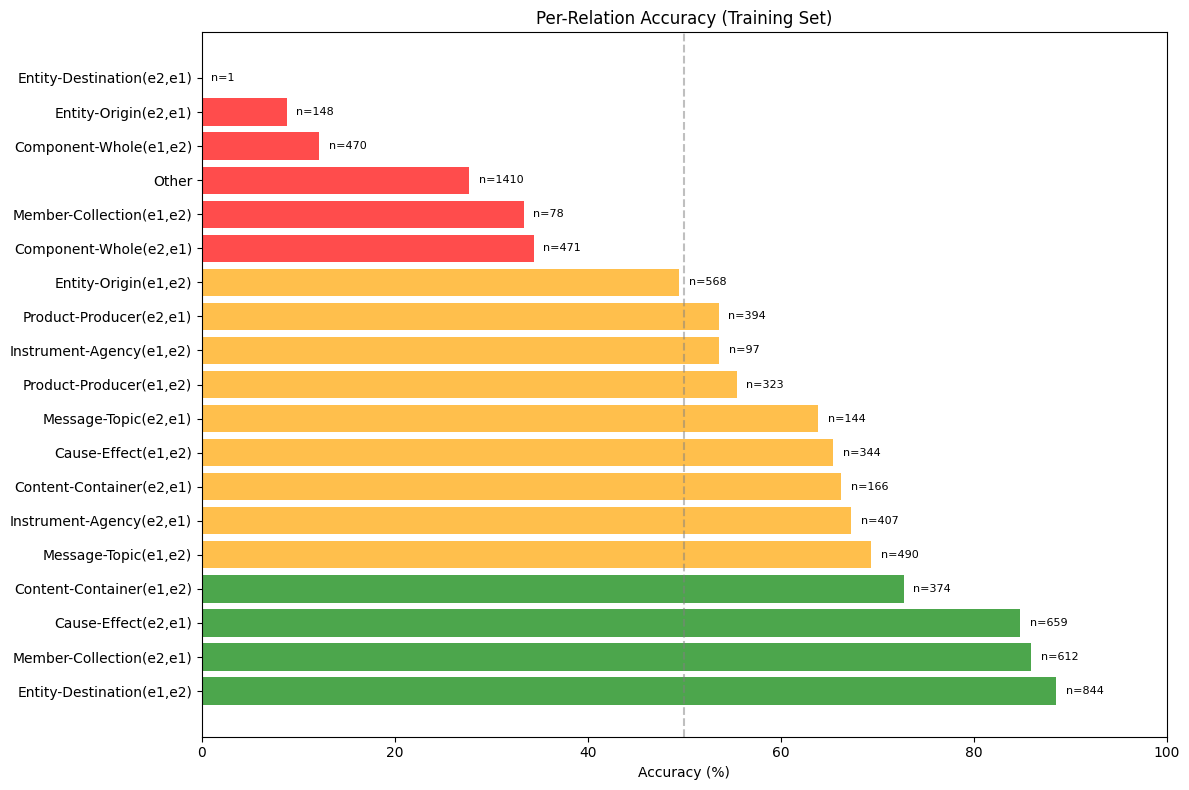

In [16]:
# Visualization: Per-relation accuracy bar chart
fig, ax = plt.subplots(figsize=(12, 8))

relations = [r[0] for r in rel_acc_sorted]
accuracies = [r[1] for r in rel_acc_sorted]
supports = [r[2] for r in rel_acc_sorted]

# Color bars by accuracy level
colors = ['green' if acc >= 70 else 'orange' if acc >= 40 else 'red' for acc in accuracies]

bars = ax.barh(relations, accuracies, color=colors, alpha=0.7)
ax.set_xlabel('Accuracy (%)')
ax.set_title('Per-Relation Accuracy (Training Set)')
ax.set_xlim(0, 100)

# Add support annotations
for i, (bar, support) in enumerate(zip(bars, supports)):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'n={support}', va='center', fontsize=8)

# Add vertical line at 50%
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.show()

## 5. M2 vs M3 Comparison

**M2 Baseline (rule-based system):**
- Test Accuracy: 49.7%
- Macro Recall: 40.2%
- Macro F1: 43.0%

**M3 with Entity-Rooted Matching:**
- Expected Train Accuracy: ~52% (validated via evaluate_training_coverage.py)
- Test Accuracy: varies based on pattern coverage

In [17]:
m2_metrics = {'accuracy': 0.497, 'recall': 0.402, 'f1': 0.430}
m3_metrics = {'accuracy': test_acc, 'recall': test_rec, 'f1': test_f1}

print('\nM2 vs M3 COMPARISON:')
print(f"{'Metric':<15} {'M2':<10} {'M3':<10} {'Change':<15}")
print('-'*50)
for metric in ['accuracy', 'recall', 'f1']:
    m2 = m2_metrics[metric]
    m3 = m3_metrics[metric]
    change = m3 - m2
    pct_change = (change / m2 * 100) if m2 > 0 else 0
    print(f"{metric:<15} {m2:<10.3f} {m3:<10.3f} {change:+.3f} ({pct_change:+.1f}%)")


M2 vs M3 COMPARISON:
Metric          M2         M3         Change         
--------------------------------------------------
accuracy        0.497      0.462      -0.035 (-7.0%)
recall          0.402      0.400      -0.002 (-0.5%)
f1              0.430      0.367      -0.063 (-14.6%)
